In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.signal import firls, filtfilt
from numpy import pi, exp, sin, logspace, mean, abs, sqrt

In [6]:
# for interactive figures
%matplotlib widget

In [7]:
# Load MATLAB data
eeg_data = loadmat('ants/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]  # Adjust based on how data is structured within the .mat file
n_trials = 6  # Modifiable
eeg_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Oct 16 15:56:57 2012',
 '__version__': '1.0',
 '__globals__': ['EEG'],
 'EEG': array([[(array(['EEG sample dataset'], dtype='<U18'), array([], dtype='<U1'), array([], dtype='<U1'), array([], dtype='<U1'), array([], dtype='<U1'), array([], dtype='<U1'), array([], shape=(0, 0), dtype=uint8), array(['Parent dataset: 15june2                                        ',
                '                                                               ',
                'Parent dataset "15june2": ----------                           ',
                'Original file: /Users/mcohen1/Desktop/simondata/raw/15june2.bdf'],
               dtype='<U63'), array([[64]], dtype=uint8), array([[99]], dtype=uint8), array([[640]], dtype=uint16), array([[256]], dtype=uint16), array([[-1]], dtype=int16), array([[1.49609375]]), array([[-1000.     ,  -996.09375,  -992.1875 ,  -988.28125,  -984.375  ,
                  -980.46875,  -976.5625 , 

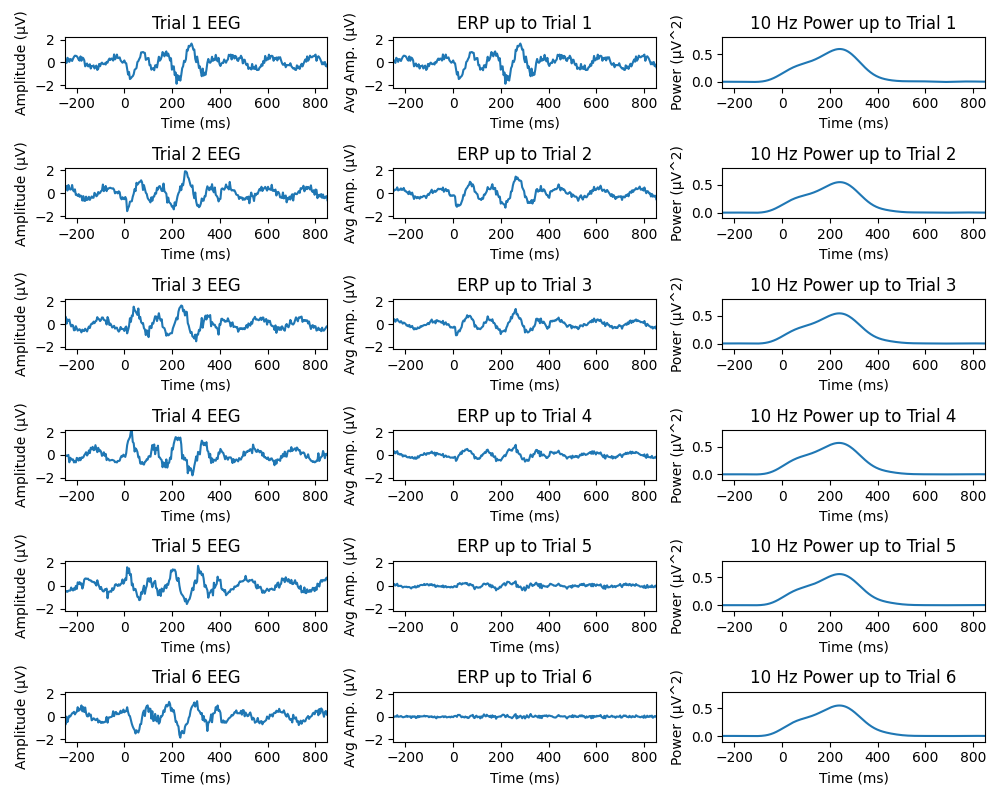

In [13]:
# Figure 2.1
plt.figure(figsize=(10, 8))
data = np.zeros((n_trials, EEG['pnts'][0][0]))

wavetime = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
n_conv = len(wavetime) + EEG['pnts'][0][0] - 1
waveletfft = fft(exp(2 * 1j * pi * 10 * wavetime) * exp(-wavetime**2 / (2 * (5 / (2 * pi * 10))**2)) / 10, n_conv)
data10hz = np.zeros((n_trials, EEG['pnts'][0][0]))

for triali in range(n_trials):
    # create single trial "ERP"
    data[triali, :] = 0.5 * sin(2 * pi * 6 * EEG['times'][0] / 1000 + 2 * pi * triali / n_trials - pi) + np.random.randn(EEG['pnts'][0][0]) / 6
    # add non-phase-locked stimulus potential (note distributed phases in sine wave)
    data[triali, 259:360] = data[triali, 259:360] + sin(2 * pi * 10 * EEG['times'][0, 259:360] / 1000 + 2 * pi * triali / n_trials - pi) + np.random.randn(101) / 5
    
    # plot data from this trial
    plt.subplot(n_trials, 3, triali * 3 + 1)
    plt.plot(EEG['times'][0], data[triali, :])
    plt.xlim([-250, 850])
    plt.ylim([-2.2, 2.2])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.title('Trial {0} EEG'.format(triali+1))

    # plot ERP from trial 1 to current
    plt.subplot(n_trials, 3, triali * 3 + 2)
    plt.plot(EEG['times'][0], mean(data[:triali+1, :], axis=0))
    plt.xlim([-250, 850])
    plt.ylim([-2.2, 2.2])
    plt.xlabel('Time (ms)')
    plt.ylabel('Avg Amp. (µV)')
    plt.title('ERP up to Trial {0}'.format(triali+1))

    # convolve with 10 Hz wavelet
    convolution_result_fft = ifft(waveletfft * fft(data[triali, :], n_conv)) * sqrt(5 / (2 * pi * 10))
    convolution_result_fft = convolution_result_fft[int(np.floor(len(wavetime)/2)): -int(np.floor(len(wavetime)/2))]
    data10hz[triali, :] = abs(convolution_result_fft)**2

    # plot 10 Hz power
    plt.subplot(n_trials, 3, triali * 3 + 3)
    plt.plot(EEG['times'][0], mean(data10hz[:triali+1, :], axis=0))
    plt.xlim([-250, 850])
    plt.ylim([-.1, .8])
    plt.xlabel('Time (ms)')
    plt.ylabel('Power (µV^2)')
    plt.title('10 Hz Power up to Trial {0}'.format(triali+1))

plt.tight_layout()
plt.show()